<a href="https://colab.research.google.com/github/sgulyano/mat202/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT-202 Lab 1: Getting Started

CMKL University

By Sarun Gulyanon


### Goal

Learn how to use a variety of Python libraries for working with different types of signals (images, time series, and audio).


### Outline

In this lab, we will explore several popular libraries:
1. [statsmodels](https://www.statsmodels.org/stable/index.html): tools for statistical modeling and time series analysis
2. [OpenCV](https://opencv.org/): computer vision and image processing
3. [Keras](https://keras.io/): data loading utilities for images, time series, and audio
4. [torchvision](https://docs.pytorch.org/vision/stable/index.html): utilities and datasets for image tasks
5. [torchaudio](https://docs.pytorch.org/audio/main/torchaudio.html): audio processing and datasets

----

# 1. statsmodels

`statsmodels` is a Python library for statistical modeling. It provides tools for:
- Descriptive statistics
- Statistical tests
- Regression models
- Time series analysis

In this lab, we'll use the [sunspots dataset](https://www.statsmodels.org/dev/datasets/generated/sunspots.html), a built-in dataset in statsmodels, and do forecasting using [Autoregression (AR)](https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html). AR is a statistical model that predicts future values of a time series based on its own past values. For example,
- `AR(1)`: predicts using the previous time step
- `AR(2)`: predicts using the two previous time steps
- and so on…

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

In [20]:
# Load monthly sunspots dataset
data = sm.datasets.sunspots.load_pandas().data
print(data.head())

# Use the "SUNACTIVITY" column as our series
ts = data["SUNACTIVITY"]
yr = data["YEAR"]

     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0


Let's fit an `AR(10)` model (using the last 10 observations to predict the next one).

In [31]:
# Split into train and test
train_size = int(len(ts) * 0.8)
train_y, test_y = yr[:train_size], yr[train_size:]
train, test = ts[:train_size], ts[train_size:]

# Fit AR(3) model
model = AutoReg(train, lags=10)
model_fit = model.fit()

print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:            SUNACTIVITY   No. Observations:                  247
Model:                    AutoReg(10)   Log Likelihood                -957.345
Method:               Conditional MLE   S.D. of innovations             13.742
Date:                Thu, 18 Sep 2025   AIC                           1938.689
Time:                        01:24:56   BIC                           1980.306
Sample:                            10   HQIC                          1955.463
                                  247                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.0455      2.750      2.925      0.003       2.655      13.436
SUNACTIVITY.L1      1.2259      0.066     18.677      0.000       1.097       1.355
SUNACTIVITY.L2     -0.5048      

Make predictions and plot the forecasting results

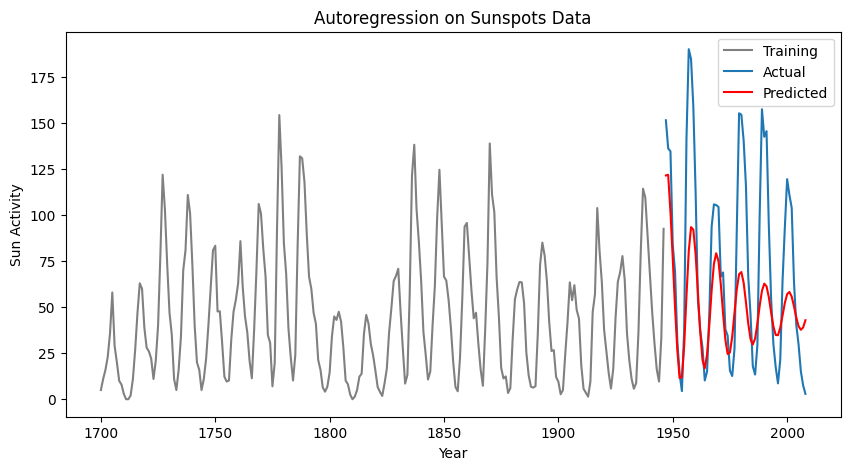

In [32]:
# Predict on the test set
preds = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Compare actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(train_y, train.values, label="Training", color="grey")
plt.plot(test_y, test.values, label="Actual")
plt.plot(test_y, preds.values, label="Predicted", color="red")
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.title("Autoregression on Sunspots Data")
plt.show()

# 2. OpenCV

OpenCV is a popular open-source computer vision library. It provides functions for image processing, feature detection, object tracking, and more.

In this lab, we'll use OpenCV to perform foreground extraction using the [GrabCut algorithm](https://dl.acm.org/doi/10.1145/1186562.1015720). It segments the foreground (main object) from the background using iterative [graph cuts](https://en.wikipedia.org/wiki/Graph_cuts_in_computer_vision). This method requires an initial guess (rectangle or mask), then it will produce a binary segmentation mask (foreground vs. background).

We will use a sample image from [scikit-image](https://scikit-image.org/).

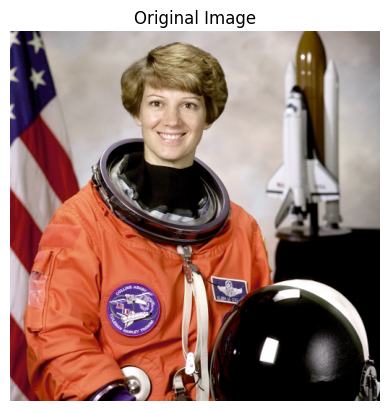

In [38]:
from skimage import data

# Use astronaut image from skimage
img = data.astronaut()   # returns RGB image
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

Define an initial guess as a rectangle around foreground.

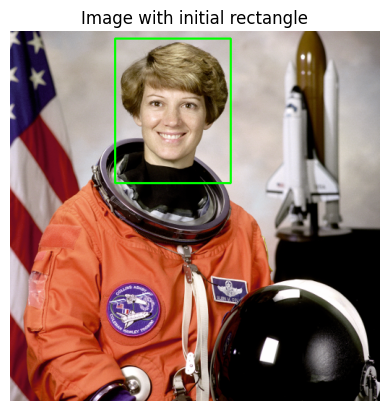

In [66]:
import cv2
import numpy as np

# Create an initial mask
mask = np.zeros(img.shape[:2], np.uint8)

# Models for background and foreground (internal use by GrabCut)
bg_model = np.zeros((1, 65), np.float64)
fg_model = np.zeros((1, 65), np.float64)

# Rectangle around the astronaut (x, y, width, height)
rect = (145, 10, 160, 200)

# Draw the rectangle on a copy of the image
img_with_rect = img.copy()
cv2.rectangle(img_with_rect, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0, 255, 0), 2)

# Display the image with the rectangle
plt.imshow(img_with_rect)
plt.title("Image with initial rectangle")
plt.axis("off")
plt.show()

Apply GrabCut

In [67]:
cv2.grabCut(img, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)

# Post-process the mask
# 0,2 = background -> 0; 1,3 = foreground -> 1
mask2 = np.where((mask==2)|(mask==0), 0, 1).astype("uint8")

# Extract the foreground
foreground = img * mask2[:, :, np.newaxis]

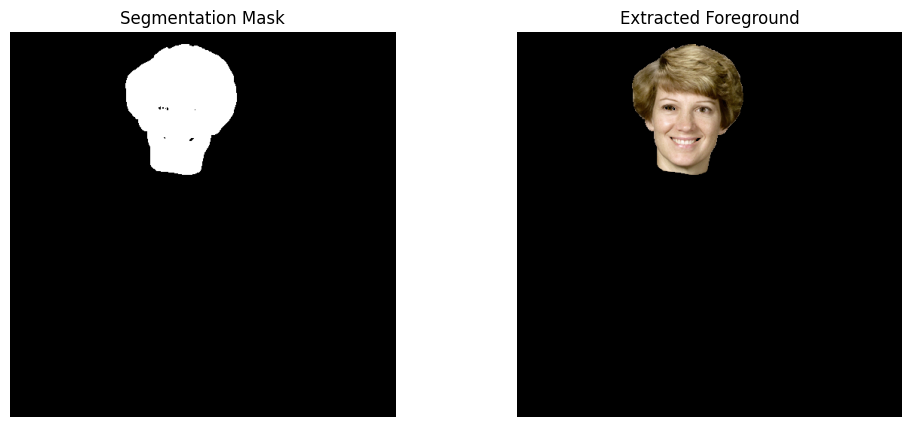

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(mask2, cmap="gray")
axes[0].set_title("Segmentation Mask")
axes[0].axis("off")

axes[1].imshow(foreground)
axes[1].set_title("Extracted Foreground")
axes[1].axis("off")

plt.show()

# 3. Keras

Keras is a popular deep learning API. In this lab, we will use Keras along with [librosa](https://librosa.org/doc/latest/index.html) to process audio by converting it into features such as spectrograms or MFCCs.

Audio shape: (22050,)
Sample rate: 22050


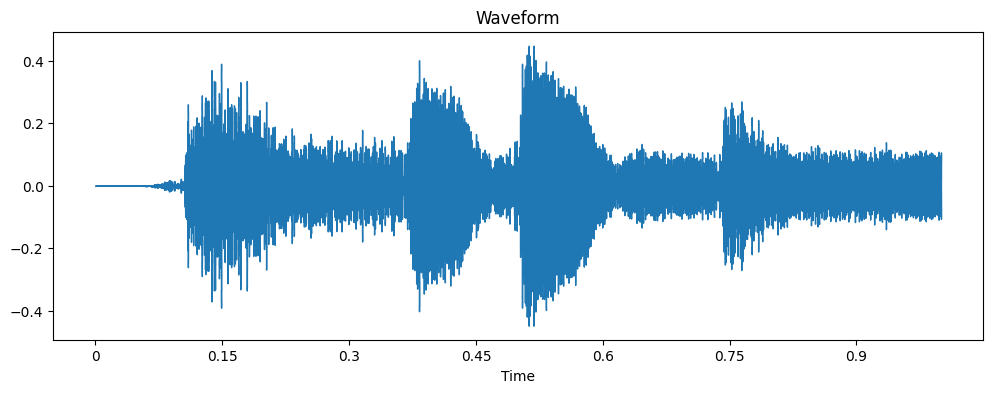

In [78]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio file (librosa provides a sample music file)
y, sr = librosa.load(librosa.ex('pistachio'))

# Keep only the first second
y = y[:sr]

print("Audio shape:", y.shape)
print("Sample rate:", sr)

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

In [79]:
import IPython.display as ipd

# Play the audio
ipd.Audio(y, rate=sr)

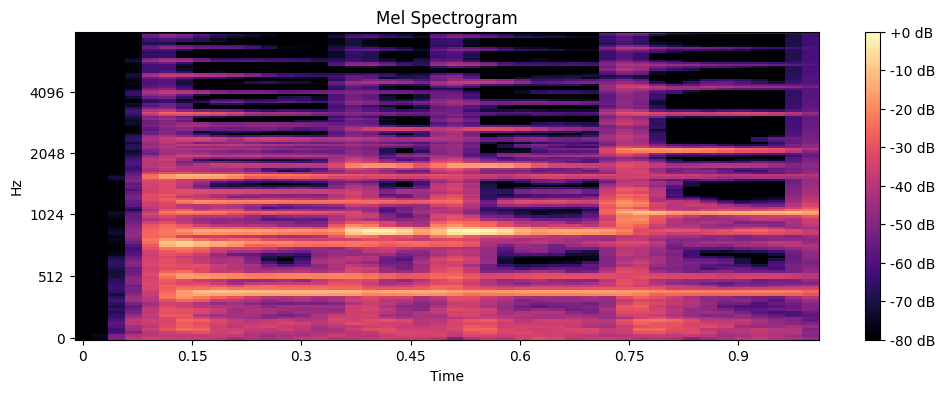

In [80]:
# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

# Convert to log scale (dB)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", fmax=8000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.show()

# 4. torchvision

torchvision is a PyTorch library that provides
- Popular datasets (CIFAR-10, MNIST, ImageNet)
- Pretrained models (ResNet, VGG, etc.)
- Image transformations (resizing, normalization, augmentation)

In this lab, we will use a pretrained model [MobileNet_V2](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html) to classify image.

In [101]:
import torch
from torchvision import models, transforms
from skimage import data
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Load pretrained MobileNetV2 and get preprocessing transform.

In [102]:
# Load pretrained weights
weights = models.MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)
model.eval()  # set to evaluation mode

# Get recommended preprocessing transform
preprocess = weights.transforms()

Load and preprocess the image

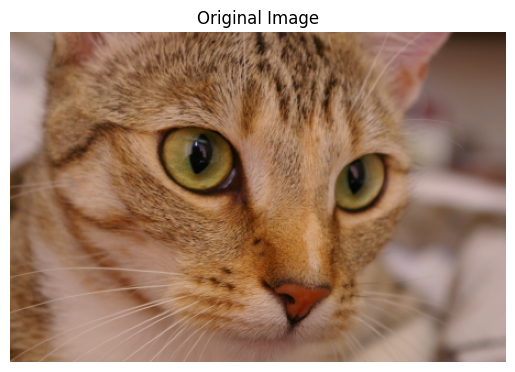

In [103]:
# Load sample image
img = data.cat()  # grayscale image

plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

# Convert to PIL image for transforms
img_pil = Image.fromarray(img)

input_tensor = preprocess(img_pil)
input_batch = input_tensor.unsqueeze(0)  # create batch dimension

Run inference

In [104]:
# Ensure model and input are on the same device (CPU for now)
device = torch.device("cpu")
model.to(device)
input_batch = input_batch.to(device)

# Forward pass
with torch.no_grad():
    output = model(input_batch)

# Probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

Decode top predictions

In [105]:
# Download ImageNet class labels
import json
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_idx = [line.strip() for line in urllib.request.urlopen(url)]

# Get top-5 predictions
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(f"{class_idx[top5_catid[i]]}: {top5_prob[i].item():.4f}")

b'Egyptian cat': 0.2172
b'tiger cat': 0.1973
b'tabby': 0.1405
b'lynx': 0.0195
b'Persian cat': 0.0075


# 5.torchaudio
torchaudio is a PyTorch library for audio:
- Loading audio data
- Applying transformations (spectrograms, MFCCs)
- Building datasets and pipelines for audio deep learning

In this lab, we will load a sample audio dataset and visualize waveforms and spectrograms.

In [107]:
import torch
import torchaudio
import matplotlib.pyplot as plt

Load a sample dataset

In [111]:
# Define root directory for dataset
root = "./"

# Load dataset (will download if not exists)
dataset = torchaudio.datasets.YESNO(root=root, download=True)

print("Number of samples:", len(dataset))
print("Example sample:", dataset[0])  # returns (waveform, sample_rate, label, speaker, utterance)

Number of samples: 60
Example sample: (tensor([[ 3.0518e-05,  6.1035e-05,  3.0518e-05,  ..., -1.8616e-03,
         -2.2583e-03, -1.3733e-03]]), 8000, [0, 0, 0, 0, 1, 1, 1, 1])


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Inspect a sample audio

Label: [0, 0, 0, 0, 1, 1, 1, 1], Sample rate: 8000, Shape: torch.Size([1, 50800])


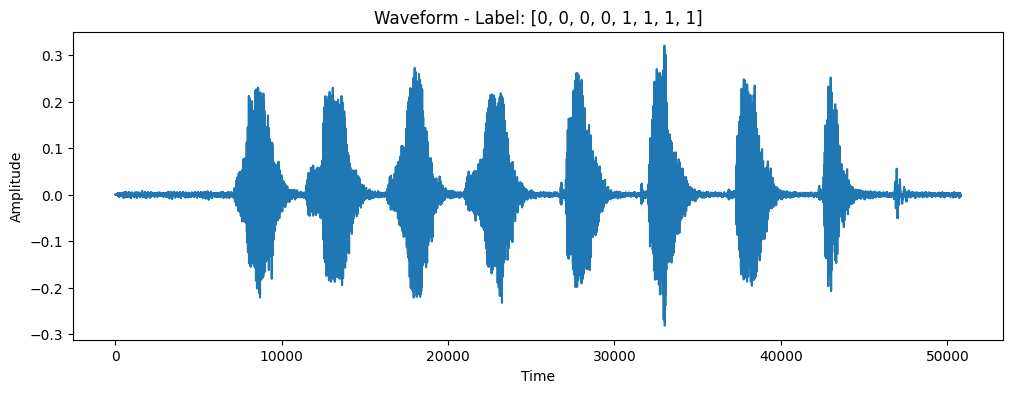

In [113]:
waveform, sample_rate, label = dataset[0]
print(f"Label: {label}, Sample rate: {sample_rate}, Shape: {waveform.shape}")

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waveform - Label: {label}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [114]:
import IPython.display as ipd

# Play the audio
ipd.Audio(waveform, rate=sample_rate)

Convert to spectrogram

Spectrogram shape: torch.Size([1, 129, 397])


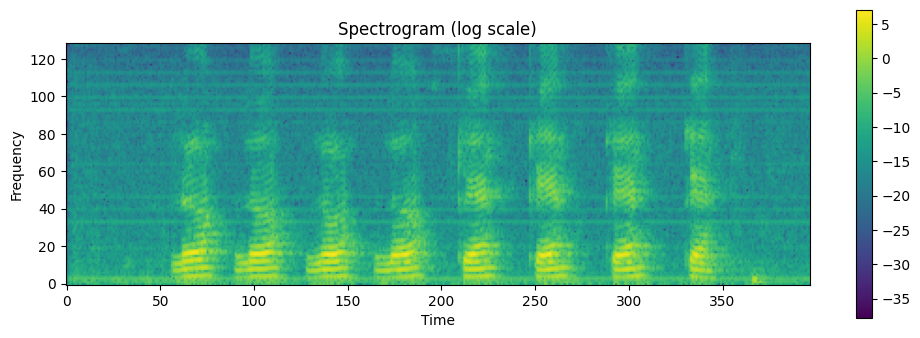

In [115]:
# Create spectrogram transform
spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=256, hop_length=128)

# Apply transform
spec = spectrogram_transform(waveform)

print("Spectrogram shape:", spec.shape)

# Plot spectrogram
plt.figure(figsize=(12, 4))
plt.imshow(spec.log2()[0, :, :].numpy(), cmap="viridis", origin="lower")
plt.title("Spectrogram (log scale)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

---